In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mouse-dynamicss/user9/session_8764610836.csv
/kaggle/input/mouse-dynamicss/user9/session_3879637058.csv
/kaggle/input/mouse-dynamicss/user9/session_3390119815.csv
/kaggle/input/mouse-dynamicss/user9/session_7285432516.csv
/kaggle/input/mouse-dynamicss/user9/session_4373781904.csv
/kaggle/input/mouse-dynamicss/user9/session_5155383252.csv
/kaggle/input/mouse-dynamicss/user9/session_0335985747.csv
/kaggle/input/mouse-dynamicss/user7/session_6668463071.csv
/kaggle/input/mouse-dynamicss/user7/session_9017095287.csv
/kaggle/input/mouse-dynamicss/user7/session_8961330453.csv
/kaggle/input/mouse-dynamicss/user7/session_1060325796.csv
/kaggle/input/mouse-dynamicss/user7/session_3320405034.csv
/kaggle/input/mouse-dynamicss/user7/session_0041905381.csv
/kaggle/input/mouse-dynamicss/user7/session_3826583375.csv


In [3]:
!pip install torchinfo pandas scikit-learn matplotlib seaborn


In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader


In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math


In [6]:
import pandas as pd

# === Load CSVs ===
# User 7 Sessions
df7_1 = pd.read_csv("/kaggle/input/mouse-dynamicss/user7/session_0041905381.csv")
df7_2 = pd.read_csv("/kaggle/input/mouse-dynamicss/user7/session_1060325796.csv")

# User 9 Sessions
df9_1 = pd.read_csv("/kaggle/input/mouse-dynamicss/user9/session_0335985747.csv")
df9_2 = pd.read_csv("/kaggle/input/mouse-dynamicss/user9/session_3390119815.csv")

# === Add Username Labels ===
for df in [df7_1, df7_2]:
    df['Username'] = 'User7'
    
for df in [df9_1, df9_2]:
    df['Username'] = 'User9'

# === Combine All Data ===
df = pd.concat([df7_1, df7_2, df9_1, df9_2], ignore_index=True)

# === Display Info ===
print("✅ Combined shape:", df.shape)
print(df.head())


✅ Combined shape: (227035, 7)
   record timestamp  client timestamp    button state    x    y Username
0               0.0             0.000  NoButton  Move  126  337    User7
1               0.0             0.016  NoButton  Move  129  337    User7
2               0.0             0.032  NoButton  Move  136  337    User7
3               0.0             0.047  NoButton  Move  155  339    User7
4               0.0             0.063  NoButton  Move  185  340    User7


In [7]:
# Drop rows with missing values
df = df.dropna(subset=['x', 'y', 'Username'])

# Normalize x and y (optional but recommended)
df['x'] = df['x'].astype(float)
df['y'] = df['y'].astype(float)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[['x', 'y']] = scaler.fit_transform(df[['x', 'y']])

# Encode user labels
label_encoder = LabelEncoder()
df['UserEncoded'] = label_encoder.fit_transform(df['Username'])

print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


Label mapping: {'User7': 0, 'User9': 1}


In [8]:
print(df.columns.tolist())


['record timestamp', 'client timestamp', 'button', 'state', 'x', 'y', 'Username', 'UserEncoded']


In [9]:
import torch
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

SEQ_LEN = 50
X, y = [], []

# ✅ Use all available data from each user (no head())
limited_df = pd.concat([
    df[df['Username'] == 'User7'],
    df[df['Username'] == 'User9']
], ignore_index=True)

# Optional: sort by timestamp to preserve movement order
limited_df = limited_df.sort_values(by='record timestamp').reset_index(drop=True)

# Re-encode user labels (if not done already)
user_encoder = LabelEncoder()
limited_df['UserEncoded'] = user_encoder.fit_transform(limited_df['Username'])

# Define feature columns
features = ['x', 'y']

# Build sequences of SEQ_LEN
for i in tqdm(range(len(limited_df) - SEQ_LEN)):
    segment = limited_df.iloc[i:i+SEQ_LEN]
    users = segment['UserEncoded']

    if len(set(users)) == 1:  # Sequence must belong to one user
        coords = segment[features].values
        X.append(coords)
        y.append(users.iloc[0])

# Convert to tensors
X = torch.tensor(X, dtype=torch.float32)  # Shape: [N, SEQ_LEN, 2]
y = torch.tensor(y, dtype=torch.long)

print(f"✅ Final Tensor Shapes: X = {X.shape}, y = {y.shape}")


100%|██████████| 226985/226985 [00:49<00:00, 4621.47it/s]


✅ Final Tensor Shapes: X = torch.Size([100677, 50, 2]), y = torch.Size([100677])


/tmp/ipykernel_35/48723058.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  X = torch.tensor(X, dtype=torch.float32)  # Shape: [N, SEQ_LEN, 2]


In [11]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)


✅ Using device: cuda


In [12]:
X_np = X.numpy()
y_np = y.numpy()

# Stratified split
X_train, X_val, y_train, y_val = train_test_split(
    X_np, y_np, test_size=0.2, stratify=y_np, random_state=42
)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)

train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_np), y=y_np)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print("Class Weights:", class_weights)


Class Weights: tensor([0.7484, 1.5065], device='cuda:0')


In [13]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2) * -math.log(10000.0) / d_model)
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.q = nn.Linear(d_model, d_model)
        self.k = nn.Linear(d_model, d_model)
        self.v = nn.Linear(d_model, d_model)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, T, D = x.shape
        H = D // self.d_k
        Q = self.q(x).view(B, T, H, self.d_k).transpose(1, 2)
        K = self.k(x).view(B, T, H, self.d_k).transpose(1, 2)
        V = self.v(x).view(B, T, H, self.d_k).transpose(1, 2)
        scores = Q @ K.transpose(-2, -1) / math.sqrt(self.d_k)
        weights = torch.softmax(scores, dim=-1)
        output = weights @ V
        output = output.transpose(1, 2).contiguous().view(B, T, D)
        return self.out(output)

class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim=128):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.norm1(x + self.attn(x))
        x = self.norm2(x + self.ff(x))
        return x

class MouseDynamicsClassifier(nn.Module):
    def __init__(self, input_dim=2, d_model=60, num_heads=6, num_layers=6, num_classes=2):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model)
        self.transformer_blocks = nn.Sequential(*[TransformerBlock(d_model, num_heads) for _ in range(num_layers)])
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_enc(x)
        x = self.transformer_blocks(x)
        x = x.mean(dim=1)  # Global mean pooling
        return self.classifier(x)

model = MouseDynamicsClassifier().to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [14]:
def train(model, train_dl, val_dl, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in tqdm(train_dl, desc=f"Epoch {epoch+1}/{epochs}"):
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = loss_fn(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for xb, yb in val_dl:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                correct += (preds.argmax(1) == yb).sum().item()
                total += yb.size(0)
        acc = correct / total
        print(f"✅ Epoch {epoch+1} | Loss: {total_loss:.4f} | Val Acc: {acc:.2%}")

train(model, train_dl, val_dl, epochs=10)


Epoch 1/10: 100%|██████████| 2517/2517 [00:32<00:00, 76.28it/s]


✅ Epoch 1 | Loss: 1368.3554 | Val Acc: 80.64%


Epoch 2/10: 100%|██████████| 2517/2517 [00:32<00:00, 78.09it/s]


✅ Epoch 2 | Loss: 961.4580 | Val Acc: 85.58%


Epoch 3/10: 100%|██████████| 2517/2517 [00:32<00:00, 77.97it/s]


✅ Epoch 3 | Loss: 778.0190 | Val Acc: 85.36%


Epoch 4/10: 100%|██████████| 2517/2517 [00:32<00:00, 78.03it/s]


✅ Epoch 4 | Loss: 625.4655 | Val Acc: 89.57%


Epoch 5/10: 100%|██████████| 2517/2517 [00:32<00:00, 77.81it/s]


✅ Epoch 5 | Loss: 533.1471 | Val Acc: 91.48%


Epoch 6/10: 100%|██████████| 2517/2517 [00:32<00:00, 76.63it/s]


✅ Epoch 6 | Loss: 467.3447 | Val Acc: 92.12%


Epoch 7/10: 100%|██████████| 2517/2517 [00:32<00:00, 78.07it/s]


✅ Epoch 7 | Loss: 408.7905 | Val Acc: 93.37%


Epoch 8/10: 100%|██████████| 2517/2517 [00:32<00:00, 78.57it/s]


✅ Epoch 8 | Loss: 371.3733 | Val Acc: 94.17%


Epoch 9/10: 100%|██████████| 2517/2517 [00:32<00:00, 78.16it/s]


✅ Epoch 9 | Loss: 332.5346 | Val Acc: 93.55%


Epoch 10/10: 100%|██████████| 2517/2517 [00:31<00:00, 78.78it/s]


✅ Epoch 10 | Loss: 296.4462 | Val Acc: 95.91%


              precision    recall  f1-score   support

       User7       0.98      0.95      0.97     13453
       User9       0.91      0.97      0.94      6683

    accuracy                           0.96     20136
   macro avg       0.95      0.96      0.95     20136
weighted avg       0.96      0.96      0.96     20136



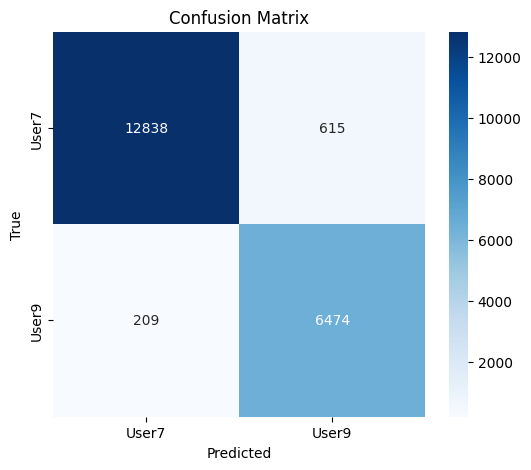

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in val_dl:
        xb = xb.to(device)
        preds = model(xb)
        y_true.extend(yb.tolist())
        y_pred.extend(preds.argmax(1).cpu().tolist())

# Report
print(classification_report(y_true, y_pred, target_names=user_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=user_encoder.classes_, yticklabels=user_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


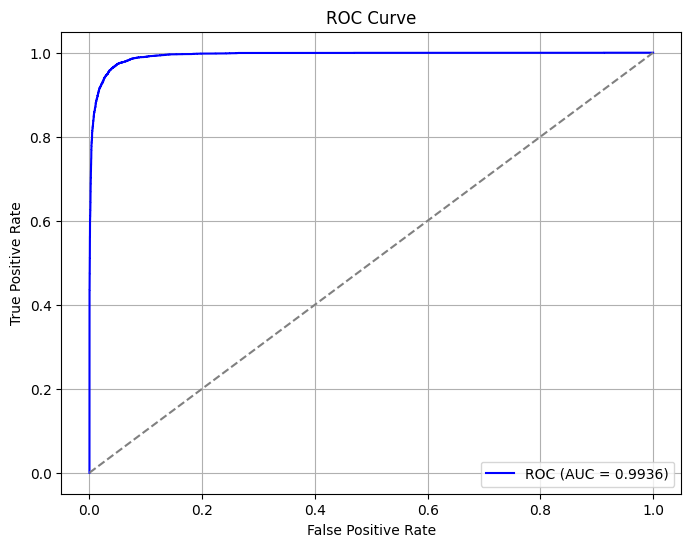

In [16]:
y_probs = []
with torch.no_grad():
    for xb, _ in val_dl:
        xb = xb.to(device)
        probs = torch.softmax(model(xb), dim=1)[:, 1]  # class 1
        y_probs.extend(probs.cpu().tolist())

auc = roc_auc_score(y_true, y_probs)
fpr, tpr, _ = roc_curve(y_true, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC (AUC = {auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
import random

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Number of test samples per user
NUM_SAMPLES = 5

print("\n🔍 Predictions on Random 5 Samples Per User\n")

for user_name in user_encoder.classes_:
    user_label = user_encoder.transform([user_name])[0]
    
    # Filter original dataframe for the user
    user_df = df[df['UserEncoded'] == user_label].reset_index(drop=True)

    print(f"--- User: {user_name} ---")

    for _ in range(NUM_SAMPLES):
        # Pick a valid random index for SEQ_LEN window
        max_start = len(user_df) - SEQ_LEN
        if max_start <= 0:
            print("Not enough data for", user_name)
            break

        start_idx = random.randint(0, max_start)
        segment = user_df.iloc[start_idx:start_idx+SEQ_LEN][['x', 'y']].values

        sample = torch.tensor([segment], dtype=torch.float32).to(device)

        with torch.no_grad():
            pred = model(sample)
            pred_class = torch.argmax(pred, dim=1).item()

        pred_user = user_encoder.inverse_transform([pred_class])[0]
        print(f"True: {user_name} | Predicted: {pred_user}")
    print()



🔍 Predictions on Random 5 Samples Per User

--- User: User7 ---
True: User7 | Predicted: User7
True: User7 | Predicted: User7
True: User7 | Predicted: User7
True: User7 | Predicted: User7
True: User7 | Predicted: User7

--- User: User9 ---
True: User9 | Predicted: User9
True: User9 | Predicted: User7
True: User9 | Predicted: User7
True: User9 | Predicted: User7
True: User9 | Predicted: User9



In [18]:
# Count total samples
print(f"📦 Total Samples: {len(X)}")

# Count train/val split
print(f"🛠️ Training Samples: {len(X_train)}")
print(f"🧪 Validation Samples: {len(X_val)}")

# Count per user in training and validation
from collections import Counter

train_dist = Counter(y_train.tolist())
val_dist = Counter(y_val.tolist())

print("\n📊 Class Distribution:")
for label in sorted(train_dist.keys()):
    user = user_encoder.inverse_transform([label])[0]
    print(f"  {user} -> Train: {train_dist[label]} | Validation: {val_dist[label]}")


📦 Total Samples: 100677
🛠️ Training Samples: 80541
🧪 Validation Samples: 20136

📊 Class Distribution:
  User7 -> Train: 53810 | Validation: 13453
  User9 -> Train: 26731 | Validation: 6683
